MOD: QAM16 bps: 4
raw bits: 8388608 pad_bits: 0 pad_syms: 4
WIQOUT= 4 | EVM_rms=0.166163 | BER=0.000722051
WIQOUT= 6 | EVM_rms=0.104244 | BER=3.69549e-06
WIQOUT= 8 | EVM_rms=0.100552 | BER=2.26498e-06
WIQOUT=10 | EVM_rms=0.100168 | BER=1.54972e-06
WIQOUT=12 | EVM_rms=0.0999712 | BER=2.02656e-06
WIQOUT=14 | EVM_rms=0.0999719 | BER=2.02656e-06
WIQOUT=16 | EVM_rms=0.100047 | BER=2.38419e-06


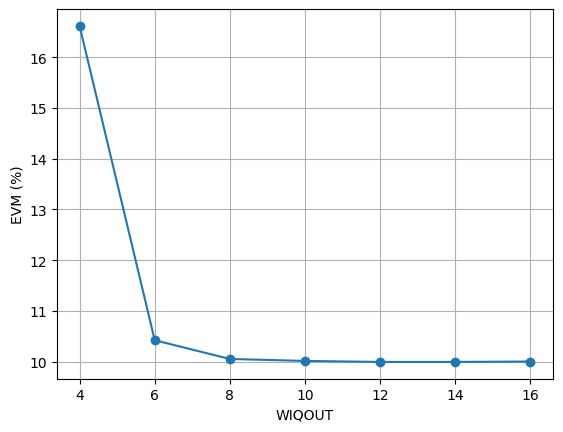

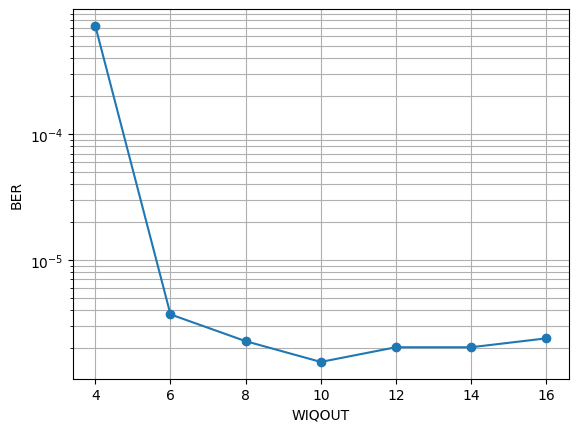

Saved recovered image: bfpA\qam16\wiqout4\recovered.png


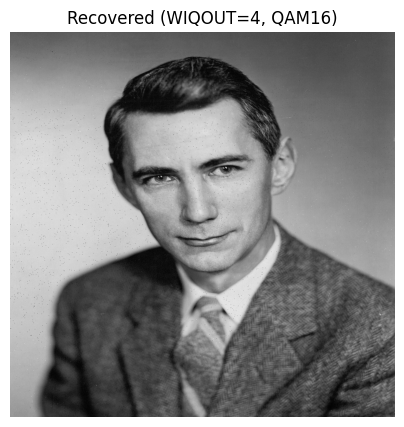

In [9]:
import os, json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

TX_DIR = "txA"
BFP_DIR = "bfpA"

def read_c64(p):
    return np.fromfile(p, dtype=np.complex64)

def read_u8(p):
    return np.fromfile(p, dtype=np.uint8)

def evm_rms(ref, test):
    refp = np.mean(np.abs(ref)**2)
    errp = np.mean(np.abs(test-ref)**2)
    return np.sqrt(errp / refp)

def bits_to_bytes(bits_u8):
    # bits_u8 are 0/1, MSB-first, length multiple of 8
    return np.packbits(bits_u8, bitorder="big")

# load meta
with open(os.path.join(TX_DIR, "meta.json"), "r", encoding="utf-8") as f:
    meta = json.load(f)

H, W = meta["H"], meta["W"]
mod_scheme = meta["mod_scheme"]
bps = meta["bps"]
n_bits_raw = meta["n_bits_raw"]
pad_bits = meta["pad_bits_to_bps"]
pad_syms = meta["pad_syms_to_block"]

print("MOD:", mod_scheme, "bps:", bps)
print("raw bits:", n_bits_raw, "pad_bits:", pad_bits, "pad_syms:", pad_syms)

# tx reference
tx_bits = read_u8(os.path.join(TX_DIR, "tx_bits.u8"))    # padded-to-bps
tx_syms = read_c64(os.path.join(TX_DIR, "tx_syms.c64"))  # padded-to-BLOCK_LEN

# sweep results
wiqout_list = sorted([int(d.replace("wiqout","")) for d in os.listdir(os.path.join(BFP_DIR, mod_scheme.lower()))
                      if d.startswith("wiqout")])

bers, evms = [], []
for wiqout in wiqout_list:
    sub = os.path.join(BFP_DIR, mod_scheme.lower(), f"wiqout{wiqout}")
    rx_syms = read_c64(os.path.join(sub, "rx_syms.c64"))
    rx_bits = read_u8(os.path.join(sub, "rx_bits.u8"))

    # align lengths (should match, but be safe)
    n_sym = min(tx_syms.size, rx_syms.size)
    e = evm_rms(tx_syms[:n_sym], rx_syms[:n_sym])

    n_bits = min(tx_bits.size, rx_bits.size)
    # BER should be computed over the "true" image bits only:
    # drop the pad bits (to bps) by restricting to n_bits_raw
    n_eval = min(n_bits_raw, n_bits)  # raw bits count is the image payload bits
    ber = np.mean(tx_bits[:n_eval] != rx_bits[:n_eval])

    evms.append(e); bers.append(ber)

    print(f"WIQOUT={wiqout:2d} | EVM_rms={e:.6g} | BER={ber:.6g}")

# Plot
plt.figure()
plt.plot(wiqout_list, [100*e for e in evms], marker="o")
plt.xlabel("WIQOUT")
plt.ylabel("EVM (%)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(wiqout_list, bers, marker="o")
plt.xlabel("WIQOUT")
plt.ylabel("BER")
plt.yscale("log")
plt.grid(True, which="both")
plt.show()

# Recover an image for one chosen WIQOUT (e.g., best or a specific one)
WIQOUT_SHOW = 4   # choose 16 by default
sub = os.path.join(BFP_DIR, mod_scheme.lower(), f"wiqout{WIQOUT_SHOW}")
rx_bits = read_u8(os.path.join(sub, "rx_bits.u8"))

# take only payload bits -> bytes -> image
payload_bits = rx_bits[:n_bits_raw]
payload_bytes = bits_to_bytes(payload_bits)  # length should be H*W
img_u8 = payload_bytes[:H*W].reshape(H, W).astype(np.uint8)

out_png = os.path.join(sub, "recovered.png")
Image.fromarray(img_u8, mode="L").save(out_png)
print("Saved recovered image:", out_png)

plt.figure(figsize=(5,5))
plt.imshow(img_u8, cmap="gray")
plt.title(f"Recovered (WIQOUT={WIQOUT_SHOW}, {mod_scheme})")
plt.axis("off")
plt.show()
